# ASDSI - Exercise sheet 3, 2022

## Lezhong Shen

In [1]:
from stargazer.stargazer import Stargazer
from linearmodels import IV2SLS
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stargazer.stargazer import Stargazer
from linearmodels.iv import IV2SLS
import sklearn.linear_model

## 1 Instrumental Variables in found data:

### 1.1 Facebook Posts and Mood, using weather as an instrument

In [2]:
df = pd.read_csv('fbmood1.csv')
df

,badweather_friends,badweather_local,raindev_friends,dailyposts,negtweet1,negtweet2,negtweet3,mood
0,0,0,-0.910498,2.24,0,1,0,6
1,0,0,-1.238619,2.16,0,0,0,7
2,0,1,-0.081423,2.74,0,0,0,7
3,0,0,-1.860924,3.88,1,0,1,6
4,0,0,-1.258945,1.53,0,0,0,7
...,...,...,...,...,...,...,...,...
243514,0,1,-0.967361,1.86,0,0,0,4
243515,0,1,-1.283505,2.34,0,0,0,4
243516,1,1,0.284450,2.86,1,1,1,5
243517,1,0,1.408140,2.30,1,1,1,6


#### a) Discuss the assumptions necessary for this IV approach to work and whether they are likely to hold in this setting (spend at most 10 minutes on this).

The necessary assumption is that the instrument variable *badweather_friends* affects the *mood* only through negative facebook tweets (negtweet1). Since here they just have facebook tweets data, this assumption would be true if people communicated only through Facebook statuses. However, people will actually use other social media platforms like twitter etc. that is connected to facebook to express negative messages. Therefore, this exclusion restriction assumption is unlikely to hold here.

#### b) Test whether the first stage relationship exists and also conduct a covariate balance check using an appropriate predetermined covariate. Do your results validate the use of this IV approach?

In [3]:
#test first stage

df_est = smf.ols('negtweet1~badweather_friends+badweather_local', data=df).fit(cov_type='HC3')
df_est.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.2670,0.001,179.617,0.000,0.264,0.270
badweather_friends,0.3395,0.002,176.579,0.000,0.336,0.343
badweather_local,-0.0010,0.002,-0.510,0.610,-0.005,0.003


**Interpretation**: From the result, we can see that whether the majority of the individual’s out-of-town Facebook friends are in cities has effect on whether they will tweet negative tweets on facebook. The first stage exists.

In [4]:
# Defining covariates
covariates = ['dailyposts']

# Running covariate balance checks 

df_est1 = []
for var in covariates:
    mod = smf.ols(formula=f'{var}~badweather_friends+badweather_local', data=df).fit(cov_type='HC0')
    df_est1.append(mod)

table_result = Stargazer(df_est1)

table_result.custom_columns(covariates, [1 for i in range(len(covariates))])
table_result

**Interpretation**: The two groups (people with badweather_friends = 1 and people with badweather_friends = 0) are not signifiantly different from each other on the predetermined variable dailyposts. This means that the IV is randomly assigned. 

**Conclusion:** From the two analysis above, we can know that the first stage relationship between *negtweet1* and IV *badweather_friends* exists, and the IV is randomly assigned. These results validate the use of this IV approach.

#### c) Estimate the ITT effect (estimate the reduced form) using a linear regression. Also construct a 95 pct confidence interval.

In [5]:
df_est2 = smf.ols('mood~badweather_friends+badweather_local', data=df).fit(cov_type='HC3')
df_est2.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,5.4658,0.003,1566.222,0.000,5.459,5.473
badweather_friends,-0.1160,0.004,-26.634,0.000,-0.124,-0.107
badweather_local,0.4518,0.004,103.776,0.000,0.443,0.460


**Interpretation**: The estimated ITT effect is -0.116. That means when whether there is bad weather in the local area is controlled for, the mood of a person decreases by 0.11 if the individual's friends out of town experience bad weather. Looking at the 95% confidence interval level, the effect is statistically significant. Additionally, based on the covariate balance check above, we can trust the ITT estimate captures the causal effect.

#### d) Estimate the LATE of interest using 2SLS. Also construct a 95 pct confidence interval.

In [6]:
df['const'] = 1

In [7]:
df_2sls = IV2SLS(df['mood'], df[['const','badweather_local']],df['negtweet1'],df['badweather_friends']).fit(cov_type="robust")
print(df_2sls)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   mood   R-squared:                      0.0670
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0670
No. Observations:              243519   F-statistic:                  1.11e+04
Date:                Thu, Feb 24 2022   P-value (F-stat)                0.0000
Time:                        21:11:47   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                5.5570     0.0059     938.33     0.0000      5.5454      5.5686
badweather_local     0.4515 

In [8]:
df_2sls.conf_int(0.95)

,lower,upper
const,5.545400,5.568615
badweather_local,0.443046,0.459886
negtweet1,-0.366300,-0.316679


**Interpretation**: When choosing *badweather_friends* as IV, the LATE of posting negative facebook tweets on mood is -0.3415. This represents that when controlling for local bad weather, the mood of individuals that experience bad weather is 0.3415 lower than the mood of those experiencing not bad weather. The effect is statistically significant at the 95% confidence interval level.

#### e) Using raindev friends as the instrument, estimate the LATE of interest using 2SLS. Also construct a 95 pct confidence interval. Compare to your result under d).

In [9]:
df_2sls_1 = IV2SLS(df['mood'], df[['const','badweather_local']],df['negtweet1'],df['raindev_friends']).fit(cov_type="robust")
print(df_2sls_1)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   mood   R-squared:                      0.0669
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0669
No. Observations:              243519   F-statistic:                 1.079e+04
Date:                Thu, Feb 24 2022   P-value (F-stat)                0.0000
Time:                        21:11:48   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                5.5525     0.0072     770.37     0.0000      5.5384      5.5666
badweather_local     0.4508 

In [10]:
df_2sls_1.conf_int(0.95)

,lower,upper
const,5.538395,5.566648
badweather_local,0.442254,0.459282
negtweet1,-0.362227,-0.298593


**Interpretation**: When choosing *raindev_friends* as IV, the LATE of posting negative facebook tweets on mood is -0.3304. The effect is statistically significant at the 95% confidence interval level. This result is very close to the LATE of using *badweather_friends* as IV.

#### f) Assume we are now interested in the causal effect of negtweet2 on mood, which we again want to estimate using badweather friends as an instrument. Estimate the ITT effect and the LATE in this case. Compare to your answers under d)

In [11]:
# ITT
df_est3 = smf.ols('mood~badweather_friends+badweather_local', data=df).fit(cov_type='HC3')
df_est3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,5.4658,0.003,1566.222,0.000,5.459,5.473
badweather_friends,-0.1160,0.004,-26.634,0.000,-0.124,-0.107
badweather_local,0.4518,0.004,103.776,0.000,0.443,0.460


In [12]:
# LATE
df_2sls_2 = IV2SLS(df['mood'], df[['const','badweather_local']],df['negtweet2'],df['badweather_friends']).fit(cov_type="robust")
print(df_2sls_2)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   mood   R-squared:                      0.0386
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0386
No. Observations:              243519   F-statistic:                 1.077e+04
Date:                Thu, Feb 24 2022   P-value (F-stat)                0.0000
Time:                        21:11:49   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                5.6098     0.0078     720.19     0.0000      5.5945      5.6251
badweather_local     0.4516 

**Interpretation**: The ITT effect is the same as using *negtweet1*. When choosing *badweather_friends* as IV, the LATE of *negtweet2* is -0.4475. The effect is statistically significant at the 95% confidence interval level. In d) it's -0.3415. They are both negative, though the magnitude of *negtweet2*'s LATE is larger.

#### g) Assume finally we are interested in the causal effect of negtweet3 on mood, which we again want to estimate using badweather friends as an instrument. Estimate the ITT effect and the LATE in this case. Compare to your answers under f) and d).

In [13]:
# ITT
df_est4 = smf.ols('mood~badweather_friends+badweather_local', data=df).fit(cov_type='HC3')
df_est4.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,5.4658,0.003,1566.222,0.000,5.459,5.473
badweather_friends,-0.1160,0.004,-26.634,0.000,-0.124,-0.107
badweather_local,0.4518,0.004,103.776,0.000,0.443,0.460


In [14]:
# LATE
df_2sls_3 = IV2SLS(df['mood'], df[['const','badweather_local']],df['negtweet3'],df['badweather_friends']).fit(cov_type="robust")
print(df_2sls_3)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   mood   R-squared:                      0.0583
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0583
No. Observations:              243519   F-statistic:                   1.1e+04
Date:                Thu, Feb 24 2022   P-value (F-stat)                0.0000
Time:                        21:11:50   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                5.5286     0.0051     1093.7     0.0000      5.5187      5.5385
badweather_local     0.4513 

**Interpretation**: The ITT effect is the same as previous. When choosing *badweather_friends* as IV, the LATE of *negtweet3* is -0.2339. The effect is statistically significant at the 95% confidence interval level. This is also negative as before but the magnitude of this LATE is smaller than that in d) and f).

**Conclusion**: Even if we use the same IV *badweather_friends*, the *badweather_friends* can affect the outcome *mood* differently when we change the measure of $D_i$. Although the effects are different in the magnitude, they are all negative and the difference is not very big.

### 1.2 Evaluating IV-designs

**a) Say you are a researcher and one of your colleagues presents an idea of how to estimate the causal effect of having more than two chil- dren on labor market participation. Now knowing very well that the number of children people choose to have is not likely to be randomly assigned, your colleague suggests using an Instrumental Variables ap- proach. Specifically, using data on a sample of parents who already have two kids, your colleague suggests using the parents’ number of siblings as an instrument for her likelihood of having at least one more child. Discuss whether this approach is likely to provide credible esti- mates of the treatment effect of interest.**

I think this IV is likely to have some problems. First, we can intuitively think that parents having more siblings may have higher chance to have more than one kid. However, it is doubtful that whether this will affect them to have more than two kids. We can assume that the number of parents' sibilings affect labor participation through number of kids. However, the data here is just the sample of parents with two kids(so we only can measure the likelihood of having the third kid), and lack the data of parents with one kid(to predict the likelihood of having the second kid). The number of parents' sibling may affect the outcome through the likelihood of having two kids. The exclusion restriction assumption is problematic here. Finally, the number of parents' sibling may not be random. The number of siblings may be related to other factors like region, culture or income which may affect the labor market participation.

**b) Debating back and forth, your colleague has another suggestion, as she has observed a tendency among her friends and family. Parents who have two children with the same sex (at birth) seem to be more likely to get a third child. She has the sense that this might be because many couples dream about trying to raise both a boy and a girl at least once. Based on this empirical regularity, your colleague suggests using a variable indicating if the sex of the first two children are the same, as an instrument for having more than two kids. Discuss whether this approach is likely to provide credible estimates of the treatment effect of interest.**

I feel like this approach is likely to provide a credible estimates of the treatment effect. First, whether parents have two children with the same sex is empirically relevant to whether they are more likely to have a third child. The first stage exists. Second, intuitively it seems that whether parents have two children with the same sex has no direct effect on the labor market participation. It's hard to find some explainations on if parents have two boys or two girls they will have higher or lower labor participation. Therefore, it seems reasonable to assume that whether parents have two children with the same sex can only affect labor market participation through the likelihood of haveing more than two kids.

**c) A third colleague overhears your discussion. He is very interested in the effects of going on maternity leave on later earnings and is also interested in using a instrumental variable approach. Since having a third child means going on maternity leave (at least) once more, he wants to use the indicator variable for whether the genders of the first two children are the same as an instrument for going on maternity leave a third time.**

Here the researcher wants to study the effects of going on maternity leave on later earnings and he doesn't tend to just focus on the effect of the maternity with a specific frequency. However, if he chooses whether parents have two children with the same sex as IV, he only can study the effect of the likelihood of going on a third maternity on later earnings. In this case he can't study the effect of the first and second maternity on earnings. Therefore, since the generalization of the result is limited and can't fulfill his research interest, the IV is not ideal here.

**d) Another colleague of yours is deeply concerned with the return to education, i.e. the effect of attending university on future wages. Now she is aware that educational choice is very non-random, so she wants to use an IV approach with the distance from your home town to the nearest university as an instrument for attending university. Discuss whether this approach is likely to provide credible estimates of the treatment effect of interest.**

In this case, we may need to consider whether the distance from one's hometown to the nearest university is relevant to the attendance of university in certain context. For instance, in some countries, whether an individual can attend the university depends on the National College Entrance Examination. They can't just enter an university just because they live nearby. Additionally, the choice of the university is also affected by other factors, like the reputation of the university. Therefore, the relationship between distance and university attendance is not certain. What's more, it is also possible that the distance from home to the neartest university may have direct effect on future wages. It is possible that accommodations near the universities will have higer cost than other areas in the city, so people who live near the university may have higher family income. It is possible that people coming from higher income family(more social resource, good education) will have higher future wages. Therefore, the credibility of this IV should be concerned.

## 2 Differences-in-Differences:

### 2.1 Do COVID19 lockdowns work? Evidence from the Danish ’mink-gate’ lockdown

**a) Open the raw data and keep only observations from time period 0 (the week just before the lockdown) and time period 2 (the week after the lockdown was introduced).**

In [15]:
df2 = pd.read_csv('muni_covid1.csv')
df2

,muni_name,muni_id,year,week,weekrun,time,cases,lockdown
0,København,101,2020,13,13,-33,130,0
1,København,101,2020,14,14,-32,126,0
2,København,101,2020,15,15,-31,251,0
3,København,101,2020,16,16,-30,432,0
4,København,101,2020,17,17,-29,331,0
...,...,...,...,...,...,...,...,...
4895,Hjørring,860,2021,5,58,12,64,1
4896,Hjørring,860,2021,6,59,13,29,1
4897,Hjørring,860,2021,7,60,14,15,1
4898,Hjørring,860,2021,8,61,15,8,1


In [16]:
df2_lockdown = df2.loc[(df2['time']==0)|(df2['time']==2)].copy()
df2_lockdown

,muni_name,muni_id,year,week,weekrun,time,cases,lockdown
33,København,101,2020,46,46,0,1267,0
35,København,101,2020,48,48,2,1279,0
83,Frederiksberg,147,2020,46,46,0,195,0
85,Frederiksberg,147,2020,48,48,2,146,0
133,Ballerup,151,2020,46,46,0,129,0
...,...,...,...,...,...,...,...,...
4785,Jammerbugt,849,2020,48,48,2,17,1
4833,Aalborg,851,2020,46,46,0,419,0
4835,Aalborg,851,2020,48,48,2,192,0
4883,Hjørring,860,2020,46,46,0,77,1


**b) Construct a time dummy for period 2. Also construct interaction terms between this time dummy and the treatment dummy (remember that the treatment here is the lockdown).**

In [17]:
df2_lockdown['time_dummy'] = [1 if time ==2 else 0 for time in df2_lockdown['time']]
df2_lockdown['interaction_term'] = df2_lockdown['lockdown']*df2_lockdown['time_dummy']

In [18]:
df2_lockdown

,muni_name,muni_id,year,week,weekrun,time,cases,lockdown,time_dummy,interaction_term
33,København,101,2020,46,46,0,1267,0,0,0
35,København,101,2020,48,48,2,1279,0,1,0
83,Frederiksberg,147,2020,46,46,0,195,0,0,0
85,Frederiksberg,147,2020,48,48,2,146,0,1,0
133,Ballerup,151,2020,46,46,0,129,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4785,Jammerbugt,849,2020,48,48,2,17,1,1,1
4833,Aalborg,851,2020,46,46,0,419,0,0,0
4835,Aalborg,851,2020,48,48,2,192,0,1,0
4883,Hjørring,860,2020,46,46,0,77,1,0,0


**c) Use differences-in-differences to estimate the ATT of the lockdown (in time period 2). Do this by regressing the weekly number of cases on the treatment dummy, the time dummy and the interaction terms between the two. Do these results suggest a noticeable effect of the lockdown in the week after it has been introduced?**

In [19]:
df2_lockdown_est = smf.ols('cases~lockdown+time_dummy+interaction_term', data=df2_lockdown).fit(cov_type='HC3')
df2_lockdown_est.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,78.0989,15.482,5.045,0.000,47.756,108.442
lockdown,-32.9560,18.380,-1.793,0.073,-68.980,3.068
time_dummy,0.7802,21.616,0.036,0.971,-41.586,43.147
interaction_term,-14.2088,25.949,-0.548,0.584,-65.069,36.651


In [20]:
#mannually calculate DID
result = df2_lockdown.groupby(['lockdown','time_dummy'])['cases'].mean()
control_diff = result[0].diff()
treat_diff = result[1].diff()
DID = treat_diff-control_diff
DID

time_dummy
0          NaN
1   -14.208791
Name: cases, dtype: float64

**Interpretation**: Using DID method, we can see that the effect of the lockdown on Covid cases is -14.2088. However, the effect is strongly non-significant at the 95% confidence interval level.

**d) Open the raw data and keep only observations from time period 0 until time period 12.**

In [21]:
df2_lockdown_1 = df2.loc[(df2['time']>=0)&(df2['time']<=12)].copy()
df2_lockdown_1

,muni_name,muni_id,year,week,weekrun,time,cases,lockdown
33,København,101,2020,46,46,0,1267,0
34,København,101,2020,47,47,1,1322,0
35,København,101,2020,48,48,2,1279,0
36,København,101,2020,49,49,3,1641,0
37,København,101,2020,50,50,4,1829,0
...,...,...,...,...,...,...,...,...
4891,Hjørring,860,2021,1,54,8,101,1
4892,Hjørring,860,2021,2,55,9,116,1
4893,Hjørring,860,2021,3,56,10,96,1
4894,Hjørring,860,2021,4,57,11,66,1


**e) Next construct time dummies for periods 1 to 12 (i.e. 12 new vari- ables). Also construct interaction terms between these time dummies and the treatment dummy. (Note: We are creating these dummies and interactions in order to use them in linear regressions below. If you are comfortable with letting Python handle factor and categorical variables directly in regressions (e.g. using syntax like ’C(time))’) you are welcome to do this instead and skip creating the dummies and interactions yourself. If you do so, be mindful of which category(s) are used as the baseline (which dummies and interactions are omitted).)**

I will use C function to handle time dummies and interaction terms below. I will set the time 0(one week before lockdown)as the baseline.

**f) Estimate the ATT of the lockdown in each time period after it occurs using differences-in-differences. Do this by regressing the weekly num- ber of cases on the treatment dummy, as well as the time dummies and the interaction terms from e). Do these results suggest a noticeable effect of the lockdown? Timing-wise when does this effect appear to kick in?**

In [22]:
df2_lockdown_1_est = smf.ols('cases~C(time,Treatment(reference=0))+lockdown+C(time,Treatment(reference=0))*lockdown', data=df2_lockdown_1).fit(cov_type='HC3')
df2_lockdown_1_est.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,78.0989,15.482,5.045,0.000,47.756,108.442
"C(time, Treatment(reference=0))[T.1]",-0.8242,22.100,-0.037,0.970,-44.139,42.490
"C(time, Treatment(reference=0))[T.2]",0.7802,21.616,0.036,0.971,-41.586,43.147
"C(time, Treatment(reference=0))[T.3]",12.1758,24.415,0.499,0.618,-35.677,60.029
"C(time, Treatment(reference=0))[T.4]",16.2637,26.204,0.621,0.535,-35.094,67.622
"C(time, Treatment(reference=0))[T.5]",60.3956,36.777,1.642,0.101,-11.685,132.477
"C(time, Treatment(reference=0))[T.6]",157.7582,62.985,2.505,0.012,34.310,281.207
"C(time, Treatment(reference=0))[T.7]",184.1209,57.262,3.215,0.001,71.889,296.353
"C(time, Treatment(reference=0))[T.8]",100.2308,35.583,2.817,0.005,30.489,169.972
"C(time, Treatment(reference=0))[T.9]",74.6484,28.608,2.609,0.009,18.578,130.719


**Interpretation** 

Among all results above, the effect of lockdown on Covid cases is significant at the 95% confidence interval level in time 5, 6 and 7(week 4, 5 and 6 after lockdown). Timing-wise this effect appears to kick in 4 weeks after lockdown and ends at 6 weeks after lockdown. 

The effect in time 5 $-97.2527$ means that if the municipality is affected by lockdown, the difference of cases between the week before lockdown and 4 weeks after lockdown is $97.2527$ smaller than the difference of cases between these two periods if the municipality is not affected by lockdown. The effect in time 6 $-167.1868$ means that if the municipality is affected by lockdown, the difference of cases between the week before lockdown and 5 weeks after lockdown is $167.1868$ smaller than the difference of cases between these two periods if the municipality is not affected by lockdown. The effect in time 7 $-165.978$ means that if the municipality is affected by lockdown, the difference of cases between the week before lockdown and 6 weeks after lockdown is $165.978$ smaller than the difference of cases between these two periods if the municipality is not affected by lockdown. 

**g) Discuss what assumptions need to hold in order for your estimated ATEs from f) to be credible.**

The most critical assumption of estimated ATEs in DID method is parallel trend assumption. This means that in the absence of treatment, the difference between the ‘treatment’ and ‘control’ group is constant over time.

**h) Discuss briefly which variable we should be clustering the standard error on in this setting if we follow the ’rule of thumb’ from the lecture slides.**

The rule of thunm means cluster on the level at which treatment was assigned. Here we should cluster for the different municipalities. As the treament(lockdown) is on the municipality as a whole. We should allow for dependence across observations within the same municipality but impose independence across observations with different municipalities.

**i) With only 7 of the clusters experiencing treatment here, it is likely pretty problematic to try to rely on standard errors in the first place. Nonetheless, to get some sense of the statistical uncertainty, please estimate the linear regression from c) again, obtain appropriately clus- tered standard errors for each of the ATEs and use these to construct 95 pct confidence intervals.**

In [23]:
df2_lockdown_est_cluster = smf.ols('cases~lockdown+time_dummy+interaction_term', data=df2_lockdown).fit(cov_type='cluster', 
    cov_kwds={'groups': df2_lockdown['muni_id']},use_t=True)

df2_lockdown_est_cluster.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,78.0989,15.510,5.035,0.000,47.316,108.882
lockdown,-32.9560,17.735,-1.858,0.066,-68.156,2.244
time_dummy,0.7802,4.276,0.182,0.856,-7.706,9.266
interaction_term,-14.2088,10.514,-1.351,0.180,-35.076,6.658


**Interpretation**: Clustering on the municipality level and using DID method, we can see that the effect of lockdown on the Covid cases is non-significant at the 95% confidence interval level.

**j) Open the raw data but now keep all observations from time period -8 to time period 12. Then create time dummies for each of the time periods -8 to -1 and each of the time periods 1 to 12. Finally, create interaction terms between these time dummies and the treatment dummy. (Note: We are again creating these dummies and interactions in order to use them in linear regressions below. If you are comfortable with letting Python handle factor and categorical variables directly in regressions (e.g. using syntax like ’C(time))’) you are still welcome to do this instead and skip creating the dummies and interactions yourself. If you do so, be mindful of which category(s) are used as the baseline (which dummies and interactions are omitted).)**

In [24]:
df2_lockdown_2 = df2.loc[(df2['time']>=-8)&(df2['time']<=12)].copy()
df2_lockdown_2

,muni_name,muni_id,year,week,weekrun,time,cases,lockdown
25,København,101,2020,38,38,-8,320,0
26,København,101,2020,39,39,-7,506,0
27,København,101,2020,40,40,-6,767,0
28,København,101,2020,41,41,-5,661,0
29,København,101,2020,42,42,-4,412,0
...,...,...,...,...,...,...,...,...
4891,Hjørring,860,2021,1,54,8,101,1
4892,Hjørring,860,2021,2,55,9,116,1
4893,Hjørring,860,2021,3,56,10,96,1
4894,Hjørring,860,2021,4,57,11,66,1


I will use C function to handle time dummies and interaction terms below. I will set the time 0(one week before lockdown)as the baseline.

**k) Now simultaneously estimate both the ATEs of interest and conduct a pre-trend check. Do this by regression weekly cases on the treatment dummy and all the time dummies and interactions from j). Using ap- propriately clustered standard errors, also construct 95 pct confidence intervals for the estimated coefficients on all the interaction terms. Do your results here suggest that the identifying assumptions for the difference-in-differences analysis are satisfied?**

In [25]:
df2_lockdown_2_est = smf.ols('cases~C(time,Treatment(reference=0))+lockdown+C(time,Treatment(reference=0))*lockdown', 
                             data=df2_lockdown_2).fit(cov_type='cluster', 
                                                      cov_kwds={'groups': df2_lockdown_2['muni_id']},use_t=True)
df2_lockdown_2_est.summary().tables[1]

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 27
  warnings.warn('covariance of constraints does not have full '


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,78.0989,15.546,5.024,0.000,47.245,108.953
"C(time, Treatment(reference=0))[T.-8]",-64.4615,12.084,-5.335,0.000,-88.444,-40.479
"C(time, Treatment(reference=0))[T.-7]",-55.2527,10.334,-5.347,0.000,-75.763,-34.743
"C(time, Treatment(reference=0))[T.-6]",-44.7692,7.302,-6.131,0.000,-59.261,-30.278
"C(time, Treatment(reference=0))[T.-5]",-39.7363,7.597,-5.230,0.000,-54.815,-24.658
"C(time, Treatment(reference=0))[T.-4]",-49.1099,10.459,-4.696,0.000,-69.867,-28.352
"C(time, Treatment(reference=0))[T.-3]",-50.8462,10.843,-4.689,0.000,-72.366,-29.326
"C(time, Treatment(reference=0))[T.-2]",-46.1648,9.706,-4.756,0.000,-65.428,-26.902
"C(time, Treatment(reference=0))[T.-1]",-18.3187,4.768,-3.842,0.000,-27.781,-8.856
"C(time, Treatment(reference=0))[T.1]",-0.8242,2.848,-0.289,0.773,-6.476,4.828


To check the difference of effect change over time between treament group and control group, we should look at the estimates of interaction term from time -8 to time -1. If the estimates are all close to 0, then the parallel trend assumption holds. However, we can see that the estimateds of time -8 to time -1 are all far away from 0. Therefore, the parallel trend fails.

**I) Create a graph that shows the estimated ATE of the lockdown on cases in each time period from -8 and until time period 12 (remember that in the regression from h), we can think of the estimated coefficient on the interaction between treatment and the time dummy for period -8 as estimating an ATE for period -8). Adopt the standard convention that the estimated ATE for time period 0 (the baseline period) is identically 0. If you wish you can also add error bars that show 95 pct confidence intervals for each of the estimated ATEs (of course with the exception of the ATE for period 0 where there is no meaningful confidence interval).**

In [26]:
df2_lockdown_2_est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,78.0989,15.546,5.024,0.000,47.245,108.953
"C(time, Treatment(reference=0))[T.-8]",-64.4615,12.084,-5.335,0.000,-88.444,-40.479
"C(time, Treatment(reference=0))[T.-7]",-55.2527,10.334,-5.347,0.000,-75.763,-34.743
"C(time, Treatment(reference=0))[T.-6]",-44.7692,7.302,-6.131,0.000,-59.261,-30.278
"C(time, Treatment(reference=0))[T.-5]",-39.7363,7.597,-5.230,0.000,-54.815,-24.658
"C(time, Treatment(reference=0))[T.-4]",-49.1099,10.459,-4.696,0.000,-69.867,-28.352
"C(time, Treatment(reference=0))[T.-3]",-50.8462,10.843,-4.689,0.000,-72.366,-29.326
"C(time, Treatment(reference=0))[T.-2]",-46.1648,9.706,-4.756,0.000,-65.428,-26.902
"C(time, Treatment(reference=0))[T.-1]",-18.3187,4.768,-3.842,0.000,-27.781,-8.856
"C(time, Treatment(reference=0))[T.1]",-0.8242,2.848,-0.289,0.773,-6.476,4.828


In [27]:
params = df2_lockdown_2_est.params[22:]
params

C(time, Treatment(reference=0))[T.-8]:lockdown     25.032967
C(time, Treatment(reference=0))[T.-7]:lockdown     30.824176
C(time, Treatment(reference=0))[T.-6]:lockdown     20.340659
C(time, Treatment(reference=0))[T.-5]:lockdown     10.736264
C(time, Treatment(reference=0))[T.-4]:lockdown     27.395604
C(time, Treatment(reference=0))[T.-3]:lockdown     32.560440
C(time, Treatment(reference=0))[T.-2]:lockdown     34.593407
C(time, Treatment(reference=0))[T.-1]:lockdown     19.747253
C(time, Treatment(reference=0))[T.1]:lockdown      -6.604396
C(time, Treatment(reference=0))[T.2]:lockdown     -14.208791
C(time, Treatment(reference=0))[T.3]:lockdown     -41.747253
C(time, Treatment(reference=0))[T.4]:lockdown     -49.692308
C(time, Treatment(reference=0))[T.5]:lockdown     -97.252747
C(time, Treatment(reference=0))[T.6]:lockdown    -167.186813
C(time, Treatment(reference=0))[T.7]:lockdown    -165.978022
C(time, Treatment(reference=0))[T.8]:lockdown     -61.373626
C(time, Treatment(refere

In [28]:
conf1 = df2_lockdown_2_est.conf_int()[0][22:]
conf2 = df2_lockdown_2_est.conf_int()[1][22:]

In [29]:
params_list = []
conf1_list = []
conf2_list = []

for x in params:
    params_list.append(x)
    
for x in conf1:
    conf1_list.append(x)
    
for x in conf2:
    conf2_list.append(x)

In [30]:
my_dict = {'time' : [-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10,11,12], 'ATE' : params_list, 'conf1':conf1_list,
          'conf2':conf2_list}

my_dataframe = pd.DataFrame(my_dict)

my_dataframe

,time,ATE,conf1,conf2
0,-8,25.032967,-2.338030,52.403964
1,-7,30.824176,4.262071,57.386280
2,-6,20.340659,-2.810949,43.492268
3,-5,10.736264,-8.470679,29.943206
4,-4,27.395604,4.142316,50.648893
5,-3,32.560440,5.232447,59.888433
6,-2,34.593407,6.979570,62.207243
7,-1,19.747253,2.250411,37.244094
8,1,-6.604396,-28.473586,15.264795
9,2,-14.208791,-35.124026,6.706444


In [31]:
my_dataframe.loc[7.5] = 0,0,0,0

my_dataframe = my_dataframe.sort_index().reset_index(drop=True)

my_dataframe

,time,ATE,conf1,conf2
0,-8,25.032967,-2.338030,52.403964
1,-7,30.824176,4.262071,57.386280
2,-6,20.340659,-2.810949,43.492268
3,-5,10.736264,-8.470679,29.943206
4,-4,27.395604,4.142316,50.648893
5,-3,32.560440,5.232447,59.888433
6,-2,34.593407,6.979570,62.207243
7,-1,19.747253,2.250411,37.244094
8,0,0.000000,0.000000,0.000000
9,1,-6.604396,-28.473586,15.264795


[Text(0.5, 0, 'time'), Text(0, 0.5, 'ATE')]

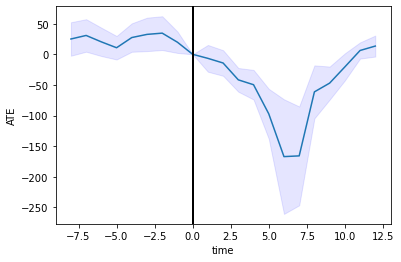

In [32]:
fig, ax = plt.subplots()
ax.plot(my_dataframe['time'],my_dataframe['ATE'])
ax.fill_between(my_dataframe['time'], my_dataframe['conf1'], my_dataframe['conf2'], color='b', alpha=.1)
ax.axvline(0,color='black',linewidth=2)
ax.set(xlabel='time',ylabel='ATE')